# Divvy Case Study - Growing Annual Memberships
### Analysis by Alex Konczal, March, 2023


## Goal -
Divvy's Chicago bike share program offers single-use passes, daily use passes, and annual memberships. Converting short-term users to annual memberships will allow Divvy to capitalize on preexisting customers' brand awareness and use; this analysis looks to identify differences between short term, 'casual' users, and users who have purchased annual memberships in order to aid marketing efforts. I'll be determining where and when users are likely to interface with Divvy bikes, and making suggestions on how Divvy can leverage this extracted information.

## Data used -
+ Divvy furnished data detailing usage of their bikes via [this link,](https://divvy-tripdata.s3.amazonaws.com/index.html) under a permissive license [found here.](https://ride.divvybikes.com/data-license-agreement) This analysis is restricted to the most recent 12 months of data available, from February 2022 through the end of January 2023; each month's data is stored as a separate CSV file, with each use constituting one record in a file. Each record consists of a unique identifier, information about where and when the trip began and ended, and whether the consumer was member or a casual user.

+ The City of Chicago offers free GIS data on its official website; from there, I obtained geometries outlining [the city boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk), [neighborhood boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9), [park boundaries](https://data.cityofchicago.org/Parks-Recreation/Parks-Chicago-Park-District-Park-Boundaries-curren/ej32-qgdr), and [major street outlines](https://data.cityofchicago.org/Transportation/Major-Streets/ueqs-5wr6).

## Tools used - 
+ numpy, and pandas for data cleaning and transformation
+ geopandas and folium for working with geographic data
+ matplotlib for data visualization

In [475]:
#data processing tools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
from matplotlib.font_manager import FontProperties
import matplotlib.colors
import matplotlib.patheffects as path_effects
import folium
from folium.plugins import BeautifyIcon
import geopandas as gpd

In [331]:
#set paths to data
dataFolder = 'C:/dataFiles/case_study_cycling/'
bikeFolder = dataFolder+'bikeFiles/'
figFolder = dataFolder+'figures/'
geoFolder = dataFolder+'geography/'
bikeFiles = os.listdir(bikeFolder)

In [98]:
#import geography data
cityDf = gpd.read_file(geoFolder+'city.geojson')
nbhdDf = gpd.read_file(geoFolder+'nbhd.geojson')
parkDf = gpd.read_file(geoFolder+'parks.geojson')

In [12]:
#import Divvy data
df0 = pd.read_csv(bikeFolder+bikeFiles[0])
df1 = pd.read_csv(bikeFolder+bikeFiles[1])
df2 = pd.read_csv(bikeFolder+bikeFiles[2])
df3 = pd.read_csv(bikeFolder+bikeFiles[3])
df4 = pd.read_csv(bikeFolder+bikeFiles[4])
df5 = pd.read_csv(bikeFolder+bikeFiles[5])
df6 = pd.read_csv(bikeFolder+bikeFiles[6])
df7 = pd.read_csv(bikeFolder+bikeFiles[7])
df8 = pd.read_csv(bikeFolder+bikeFiles[8])
df9 = pd.read_csv(bikeFolder+bikeFiles[9])
df10 = pd.read_csv(bikeFolder+bikeFiles[10])
df11 = pd.read_csv(bikeFolder+bikeFiles[11])

rawDfList = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]

## Data cleaning & transformation -
To use the provided use record files, I need to check that the individual files are of a consistent format, merge them, and ensure the data types of each field are in a usable format. Next, I'll investigate missing values and discard them where I deem appropriate. I also need to check for any inconsistent variable values and discard unused variables.

In [13]:
#comparing column names from each file to check for consistency across dataframes
rawDataColumns = []
for i in rawDfList:
    rawDataColumns.append(list(i.columns))
columnComparison = []
for i in range(0,len(rawDataColumns)-1):
    columnComparison.append(rawDataColumns[0]==rawDataColumns[i+1])
#if returned list is all Trues, then all dataframes share the same columns names.
columnComparison

[True, True, True, True, True, True, True, True, True, True, True]

In [14]:
#combining df's once sure columns are consistent
rawCollected = pd.concat(rawDfList).reset_index().drop('index', axis=1)

#getting an initial feel for the data
rawCollected.head()

ride_id rideable_type           started_at             ended_at  \
0  E1E065E7ED285C02  classic_bike  2022-02-19 18:08:41  2022-02-19 18:23:56   
1  1602DCDC5B30FFE3  classic_bike  2022-02-20 17:41:30  2022-02-20 17:45:56   
2  BE7DD2AF4B55C4AF  classic_bike  2022-02-25 18:55:56  2022-02-25 19:09:34   
3  A1789BDF844412BE  classic_bike  2022-02-14 11:57:03  2022-02-14 12:04:00   
4  07DE78092C62F7B3  classic_bike  2022-02-16 05:36:06  2022-02-16 05:39:00   

             start_station_name start_station_id  \
0        State St & Randolph St     TA1305000029   
1   Halsted St & Wrightwood Ave     TA1309000061   
2        State St & Randolph St     TA1305000029   
3  Southport Ave & Waveland Ave            13235   
4        State St & Randolph St     TA1305000029   

                 end_station_name end_station_id  start_lat  start_lng  \
0          Clark St & Lincoln Ave          13179  41.884621 -87.627834   
1  Southport Ave & Wrightwood Ave   TA1307000113  41.929143 -87.649077   
2             Canal St & Adams St          13011  41.884621 -87.627834   
3          Broadway & Sheridan Rd          13323  41.948150 -87.663940   
4           Franklin St & Lake St   TA1307000111  41.884621 -87.627834   

     end_lat    end_lng member_casual  
0  41.915689 -87.634600        member  
1  41.928773 -87.663913        member  
2  41.879255 -87.639904        member  
3  41.952833 -87.649993        member  
4  41.885837 -87.635500        member

In [15]:
#checking number of records and data types
rawAttributes = {'df_length': len(rawCollected)}
for i in rawCollected.columns:
    rawAttributes[i] = type(rawCollected[i][0])
rawAttributes

{'df_length': 5754248,
 'ride_id': str,
 'rideable_type': str,
 'started_at': str,
 'ended_at': str,
 'start_station_name': str,
 'start_station_id': str,
 'end_station_name': str,
 'end_station_id': str,
 'start_lat': numpy.float64,
 'start_lng': numpy.float64,
 'end_lat': numpy.float64,
 'end_lng': numpy.float64,
 'member_casual': str}

We've collected the data to one dataframe, but let's create a copy to make alterations to. That way, if we mess up our table somehow, we can refer back to the original before any drastic changes were made.

In [16]:
#create a dataframe for cleaning and transformation
df = rawCollected

Now that we've got a single dataframe to work with, let's begin proper cleaning. 

First, we saw the start and end date-time information is actually in the form of strings. Let's change the format to proper datetime, and extract the length of each ride from the start and end values.

In [17]:
#extract date-time, weekday, & ride duration info from trip start and end string columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df = df.assign(ride_duration = df['ended_at']-df['started_at'])

df.head()

ride_id rideable_type          started_at            ended_at  \
0  E1E065E7ED285C02  classic_bike 2022-02-19 18:08:41 2022-02-19 18:23:56   
1  1602DCDC5B30FFE3  classic_bike 2022-02-20 17:41:30 2022-02-20 17:45:56   
2  BE7DD2AF4B55C4AF  classic_bike 2022-02-25 18:55:56 2022-02-25 19:09:34   
3  A1789BDF844412BE  classic_bike 2022-02-14 11:57:03 2022-02-14 12:04:00   
4  07DE78092C62F7B3  classic_bike 2022-02-16 05:36:06 2022-02-16 05:39:00   

             start_station_name start_station_id  \
0        State St & Randolph St     TA1305000029   
1   Halsted St & Wrightwood Ave     TA1309000061   
2        State St & Randolph St     TA1305000029   
3  Southport Ave & Waveland Ave            13235   
4        State St & Randolph St     TA1305000029   

                 end_station_name end_station_id  start_lat  start_lng  \
0          Clark St & Lincoln Ave          13179  41.884621 -87.627834   
1  Southport Ave & Wrightwood Ave   TA1307000113  41.929143 -87.649077   
2             Canal St & Adams St          13011  41.884621 -87.627834   
3          Broadway & Sheridan Rd          13323  41.948150 -87.663940   
4           Franklin St & Lake St   TA1307000111  41.884621 -87.627834   

     end_lat    end_lng member_casual   ride_duration  
0  41.915689 -87.634600        member 0 days 00:15:15  
1  41.928773 -87.663913        member 0 days 00:04:26  
2  41.879255 -87.639904        member 0 days 00:13:38  
3  41.952833 -87.649993        member 0 days 00:06:57  
4  41.885837 -87.635500        member 0 days 00:02:54

In [18]:
#check for duplicate rows
duplicateRows = df[df.duplicated()]
len(duplicateRows)

0

In [19]:
#check for missing values in the variables I plan to investigate
missingBikeType = df[pd.isna(df['rideable_type'])]
missingStartTime = df[pd.isna(df['started_at'])]
missingEndTime = df[pd.isna(df['ended_at'])]
missingStartStation = df[pd.isna(df['start_station_name'])]
missingEndStation = df[pd.isna(df['end_station_name'])]
missingUserType = df[pd.isna(df['member_casual'])]

missingCounts = {'bikeType': len(missingBikeType),
                 'startTime': len(missingStartTime),
                 'endTime': len(missingEndTime),
                 'startStation': len(missingStartStation),
                 'endStation': len(missingEndStation),
                 'userType': len(missingUserType)}
missingCounts 

{'bikeType': 0,
 'startTime': 0,
 'endTime': 0,
 'startStation': 843525,
 'endStation': 902655,
 'userType': 0}

In [20]:
#count unique rows with missing data, along with incomplete rows as a percentage of total rows
missingEitherStation = set(list(missingStartStation.index) + list(missingEndStation.index))
len(missingEitherStation), "{0:.2%} of total".format(len(missingEitherStation)/len(rawCollected))

(1316732, '22.88% of total')

All rows have data on bike type, date-times for beginning and end of trip, and user type. Unfortunately, over 22% of the records are missing data on the name of either the start or end station. Since part of my plan is to make suggestions about where to focus marketing efforts, knowing the locations where consumers are likely to interface with the bikes is important. The data set also includes station codes and station coordinates, so let's see if we can use those to fill in those missing location values.

In [21]:
missingStartStation['start_station_id'].unique()

array([nan], dtype=object)

In [22]:
missingEndStation['end_station_id'].unique()

array([nan], dtype=object)

In [23]:
missingStartStation['start_lat'].unique()

array([41.91, 41.94, 41.86, 41.89, 41.88, 41.83, 41.95, 41.8 , 41.96,
       41.93, 42.01, 41.9 , 41.98, 41.92, 41.99, 41.87, 41.79, 41.81,
       41.97, 42.06, 41.68, 41.84, 42.04, 41.75, 41.74, 41.78, 41.77,
       41.85, 41.71, 41.72, 41.82, 42.02, 41.73, 42.  , 42.03, 42.05,
       41.69, 41.7 , 41.76, 41.67, 42.07, 41.65, 41.66, 41.64])

In [24]:
missingEndStation['end_lat'].unique()

array([41.9 , 41.8 , 41.91, 41.92, 41.89, 41.93, 41.81, 41.84, 41.73,
       41.88, 41.82, 41.79, 41.83, 41.86, 41.87, 41.97, 41.96, 41.94,
       41.99, 41.98, 41.95, 42.02,   nan, 42.06, 41.71, 41.78, 42.  ,
       41.77, 41.75, 41.76, 41.74, 42.05, 42.04, 41.85, 41.72, 42.03,
       42.01, 41.67, 41.69, 41.68, 41.7 , 41.66, 42.07, 41.65, 41.64,
       41.63, 42.08, 42.11, 42.1 , 42.09, 42.19, 42.12, 42.37, 42.13,
       41.62, 41.6 , 41.55, 42.15, 41.59, 41.61])

It looks like rows that are missing a station name are also missing the station id that would identify it, and the coordinates given aren't fine-grained enough t0 identify them, either. It seems reasonable to discard these rows from the analysis since station names will be important. While we're trimming data, let's remove unused columns and get rid of any ride that's less than 45 seconds long, as they're probably not legitimate rides - errors with docking and undocking the bike, etc.

In [25]:
#drop rows with missing station values
df = df.drop(missingEitherStation)

#remove unused columns
df = df.drop(['ride_id', 'ended_at', 'start_station_id', 'end_station_id'], axis=1)

df = df[df['ride_duration'] > pd.Timedelta('45 seconds')]

#check number of stations
len(df['start_station_name'].append(df['end_station_name']).unique())

C:\Users\alkon\AppData\Local\Temp\ipykernel_7460\3917345111.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  len(df['start_station_name'].append(df['end_station_name']).unique())


1648

In [26]:
#look through substations to check for irregularities, alternate spellings, etc
stationsAll = pd.concat([df['start_station_name'], df['end_station_name']])
stationsUnique = list(pd.unique(stationsAll))
stationsUnique.sort()
stationsUnique

['10101 S Stony Island Ave',
 '111th St - Morgan Park Metra',
 '2112 W Peterson Ave',
 '532 E 43rd St',
 '63rd & Western Ave - north corner',
 '63rd & Western Ave - south corner',
 '63rd St Beach',
 '83rd St (Avalon Park) Metra',
 '900 W Harrison St',
 'Abbott Park',
 'Aberdeen St & Jackson Blvd',
 'Aberdeen St & Monroe St',
 'Aberdeen St & Randolph St',
 'Ada St & 113th St',
 'Ada St & 117th St',
 'Ada St & 119th St',
 'Ada St & 79th St',
 'Ada St & 95th St',
 'Ada St & Washington Blvd',
 'Adler Planetarium',
 'Al Raby School',
 'Albany Ave & 103rd St',
 'Albany Ave & 111th St - NW',
 'Albany Ave & 16th St',
 'Albany Ave & 26th St',
 'Albany Ave & 63rd St',
 'Albany Ave & Belmont Ave',
 'Albany Ave & Bloomingdale Ave',
 'Albany Ave & Douglas Blvd',
 'Albany Ave & Montrose Ave',
 'Altgeld Gardens',
 'Archer (Damen) Ave & 37th St',
 'Archer Ave & 43rd St',
 'Archer Park',
 'Artesian Ave & 55th St',
 'Artesian Ave & Hubbard St',
 'Ashland Ave & 13th St',
 'Ashland Ave & 45th St',
 'Ashla

In [27]:
#remove substring irregularities and alternates
irregSubstr = ['Public Rack - ', ' - Charging$', ' Warehouse$', '\*$', ' (Temp)$', 'City Rack - ',
                   ' - north corner$', ' N$', ' - North$', ' - NE$', ' NW$', ' - NW$',
                   ' E$', ' - East$', ' (East)',
                   ' W$', ' - W$', ' - West$',
                   ' - south corner$', ' S$', ' - South$', ' - SE$', ' SW$', ' - SW$', 
                   ' - midblock south$', ' - midblock$',
                   ' (May)', ' Vaccination Site$', ' (NEXT Apts)', ' (NU)',
                   ' - Planet Fitness', ' - Ross Dress for Less', ' - Walmart']
df['start_station_name'] = df['start_station_name'].replace(irregSubstr, '', regex=True)
df['end_station_name'] = df['end_station_name'].replace(irregSubstr, '', regex=True)

#remove leading and trailing whitespace
df['start_station_name'] = df['start_station_name'].str.strip()
df['end_station_name'] = df['end_station_name'].str.strip()

#check number of stations after normalization
len(df['start_station_name'].append(df['end_station_name']).unique())

C:\Users\alkon\AppData\Local\Temp\ipykernel_7460\3702468181.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  len(df['start_station_name'].append(df['end_station_name']).unique())


1346

In [28]:
#check for irregular values in other attributes
list(df['rideable_type'].unique()), list(df['member_casual'].unique())

(['classic_bike', 'electric_bike', 'docked_bike'], ['member', 'casual'])

In [29]:
#check start and end coordinates for consistency
stationCoords = pd.concat([df[['start_station_name', 'start_lat', 'start_lng']].rename(columns={
                    'start_station_name':'station', 'start_lat':'lat', 'start_lng':'lon'}), 
                 df[['end_station_name', 'end_lat', 'end_lng']].rename(columns={
                     'end_station_name':'station', 'end_lat':'lat', 'end_lng':'lon'})])

coordVariations = stationCoords.groupby('station')['lat'].value_counts()
coordVariations

station                       lat      
10101 S Stony Island Ave      41.710000       6
10557 S Western Ave           41.700000       5
111th St - Morgan Park Metra  41.690000      25
2112 W Peterson Ave           41.991178    1268
                              41.991174       4
                                           ... 
Yates Blvd & 93rd St          41.726202       1
                              41.969687       1
Yates Blvd & Exchange Ave     41.770000      10
                              41.760000       2
Zapata Academy                41.840000      16
Name: lat, Length: 809756, dtype: int64

It appears some stations are listed under multiple coordinates; with the high quantity of stations, many of which see little documented use, it seems wasteful to look to clean this data now. I might clean and confirm select coordinates later if visualizing specific stations seems useful.

## Data exploration -


 Let's define some colors for later styling. Divvy bikes are typically blue with one 'unicorn' red bike; we can use [Coolor](https://coolors.co/image-picker) to extract a [color palette](https://coolors.co/231c0b-a9b1c8-f6fbf7-3db5e7-e30129) from a [Divvy marketing image](https://www.chicagotribune.com/resizer/Gbs_rwfhXKNWzI3JHulcNPZiYS8=/1024x0/filters:format(jpg):quality(70)/cloudfront-us-east-1.images.arcpublishing.com/archive.tronc/5VQXLOQSD5HZHDXQ7XZC6VRSW4.jpg) found in [this online article](https://www.chicagotribune.com/redeye/ct-redeye-xpm-2013-07-31-40972976-story.html) from the Chicago Tribune. Coolor's terms of service can be viewed [here.](https://coolors.co/terms-of-service)

<BarContainer object of 5 artists>

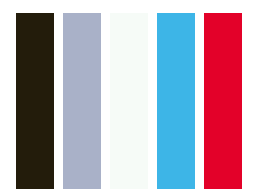

In [370]:
#color palette from Coolor: 
coolorUrl = 'https://coolors.co/231c0b-a9b1c8-f6fbf7-3db5e7-e30129'
colorList = coolorUrl.split('-')
colorList[0] = colorList[0][-6:]
colorList = ['#' + x for x in colorList]

#select representative colors for casual users, members, and total users for graphics.
colorBlack = colorList[0]
colorGray = colorList[1]
colorWhite = colorList[2]
colorCas = colorList[3]
colorMem = colorList[4]

#create color maps
cmapCas = matplotlib.colors.LinearSegmentedColormap.from_list("", [colorWhite, colorCas])
cmapMem = matplotlib.colors.LinearSegmentedColormap.from_list("", [colorWhite, colorMem])
cmapAll = matplotlib.colors.LinearSegmentedColormap.from_list("", [colorWhite, colorBlack])
cmapPalette = matplotlib.colors.LinearSegmentedColormap.from_list("", [colorCas, colorGray, colorBlack, colorWhite, colorMem])

#set some parameters for all future plots
matplotlib.rcParams['legend.frameon'] = False
for x in ['axes.edgecolor', 'axes.facecolor', 'figure.edgecolor', 'figure.facecolor', 'legend.facecolor']:
    matplotlib.rcParams[x] = colorWhite
for x in ['axes.labelcolor', 'axes.titlecolor', 'text.color', 'legend.labelcolor',
          'xtick.color', 'xtick.labelcolor', 'ytick.color', 'ytick.labelcolor']:
    matplotlib.rcParams[x] = colorBlack
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.titlesize'] = 12
for x in ['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize']:
    matplotlib.rcParams[x] = 8
    
fig, ax = plt.subplots(1,1, facecolor = 'white', dpi = 50)
ax.axis('off')
ax.bar(colorList, [1]*5, color = colorList)

Now that the data is clean, let's investigate the differences between casual users and annual members. I suspect there will be differences between when, where, and how they use shared bikes; once I identify characteristics that seperate the two, I can suggest marketing focuses for either trying to convert casual members who belong more to the use demographic of existing users, or trying to covert the casual users who are unlike existing members with a new marketing scheme appealing to their distinct preferences.

In [31]:
#split data into two dataframes - one for casual users and one for annual members.
casuals = df[df['member_casual'] == 'casual']
members = df[df['member_casual'] == 'member']

#measure total records for each type for later percentage calculations
lenCas = len(casuals)
lenMem = len(members)
lenTot = lenCas + lenMem

print(str(lenCas) + ' casual users, ' + str(lenMem) + ' annual members - ' + 
      str(round(lenCas*100/lenTot, 2)) + '/' + str(100-round(lenCas*100/lenTot, 2)) + '% split')

1752399 casual users, 2617740 annual members - 40.1/59.9% split


There's a decent difference between the sizes of the two customer bases. Let's check this split versus the split of the data before we removed records with missing location data.

In [32]:
lenRawCas = len(rawCollected[rawCollected['member_casual'] == 'casual'])
lenRawMem = len(rawCollected[rawCollected['member_casual'] == 'member'])
lenRawTot = len(rawCollected)

print(str(lenRawCas) + ' casual users, ' + str(lenRawMem) + ' annual members - ' + 
      str(round(lenRawCas*100/lenRawTot, 2)) + '/' + str(100-round(lenRawCas*100/lenRawTot, 2)) + '% split')

2343520 casual users, 3410728 annual members - 40.73/59.27% split


The splits are almost identical, so analysis on the two samples after cleaning should be fairly representative of the population. Because there's a significant difference between casual and member use numbers, I'm going to analyze use in terms of percentage of total use for each user type, that way the figures produced are comparable for the two groups.

### Use distributions - when are users riding?

let's compare useage differences between months.

<bound method Figure.show of <Figure size 1280x960 with 1 Axes>>

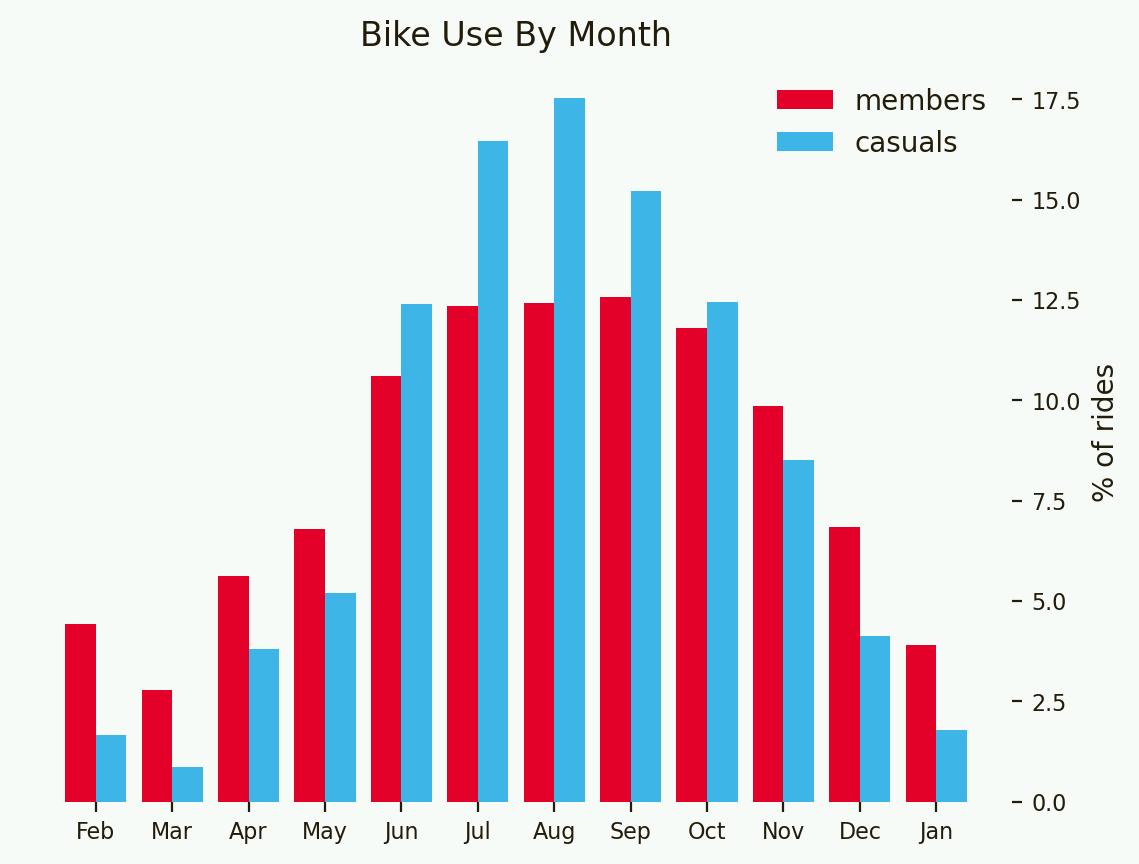

In [33]:
useMonth = pd.DataFrame({'casuals': 100*casuals['started_at'].dt.month.value_counts()/lenCas, 
                       'members': 100*members['started_at'].dt.month.value_counts()/lenMem})

#plot use by month percentages
monthLabels = np.array(['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                        'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan'])
X_axis = np.arange(len(monthLabels))

fig, ax = plt.subplots(1,1) 
ax.bar(X_axis - 0.2, list(useMonth['members']), 0.4, label = 'members', color = colorMem)
ax.bar(X_axis + 0.2, list(useMonth['casuals']), 0.4, label = 'casuals', color = colorCas)


ax.set_xticks(X_axis, monthLabels)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("% of rides")
ax.set_title("Bike Use By Month")
ax.legend()
fig.savefig(figFolder+'month.png')
fig.show

let's compare useage differences between the days of week.

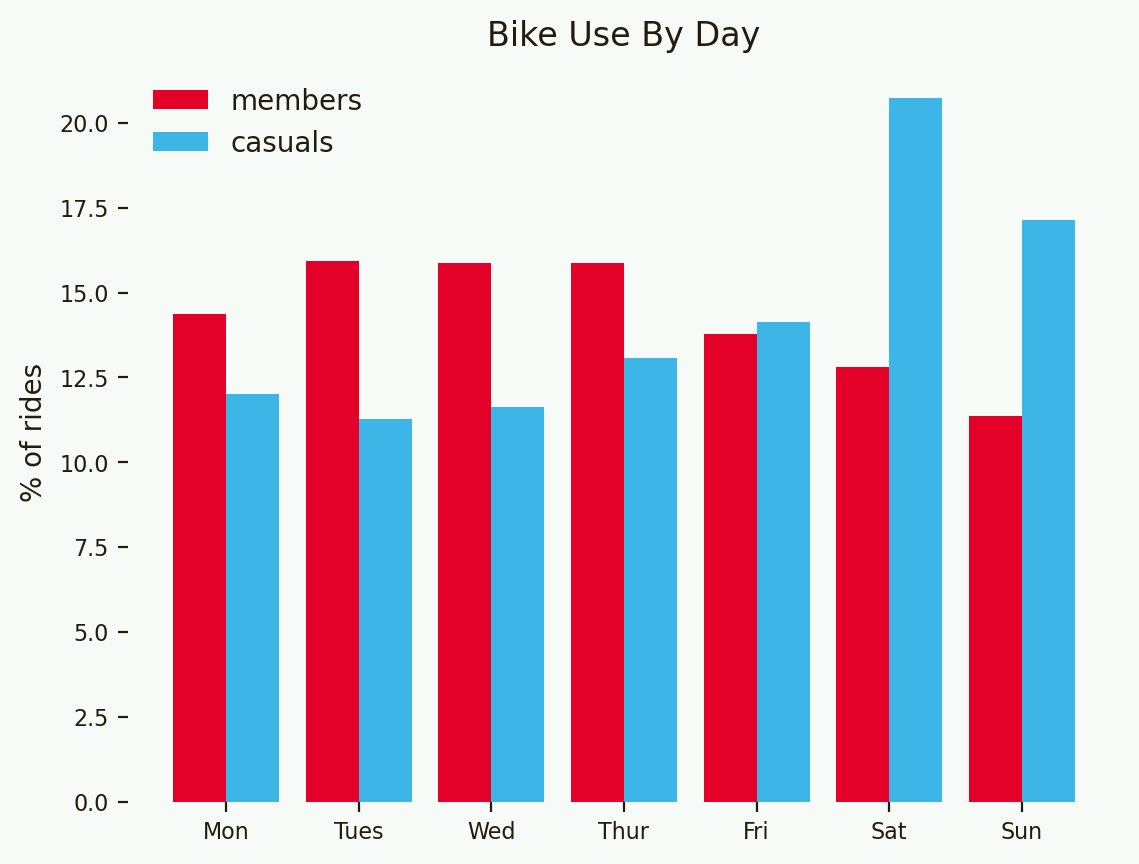

In [34]:
useDay = pd.DataFrame({'casuals': 100*casuals['started_at'].dt.day_of_week.value_counts()/lenCas, 
                       'members': 100*members['started_at'].dt.day_of_week.value_counts()/lenMem})

#plot trip day percentages
dayLabels = np.array(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
X_axis = np.arange(len(dayLabels))

plt.bar(X_axis - 0.2, list(useDay['members']), 0.4, label = 'members', color = colorMem)
plt.bar(X_axis + 0.2, list(useDay['casuals']), 0.4, label = 'casuals', color = colorCas)

plt.xticks(X_axis, dayLabels)
plt.ylabel("% of rides")
plt.title("Bike Use By Day")
plt.legend()
plt.savefig(figFolder+'day.png')
plt.show()

let's compare useage differences between start times.

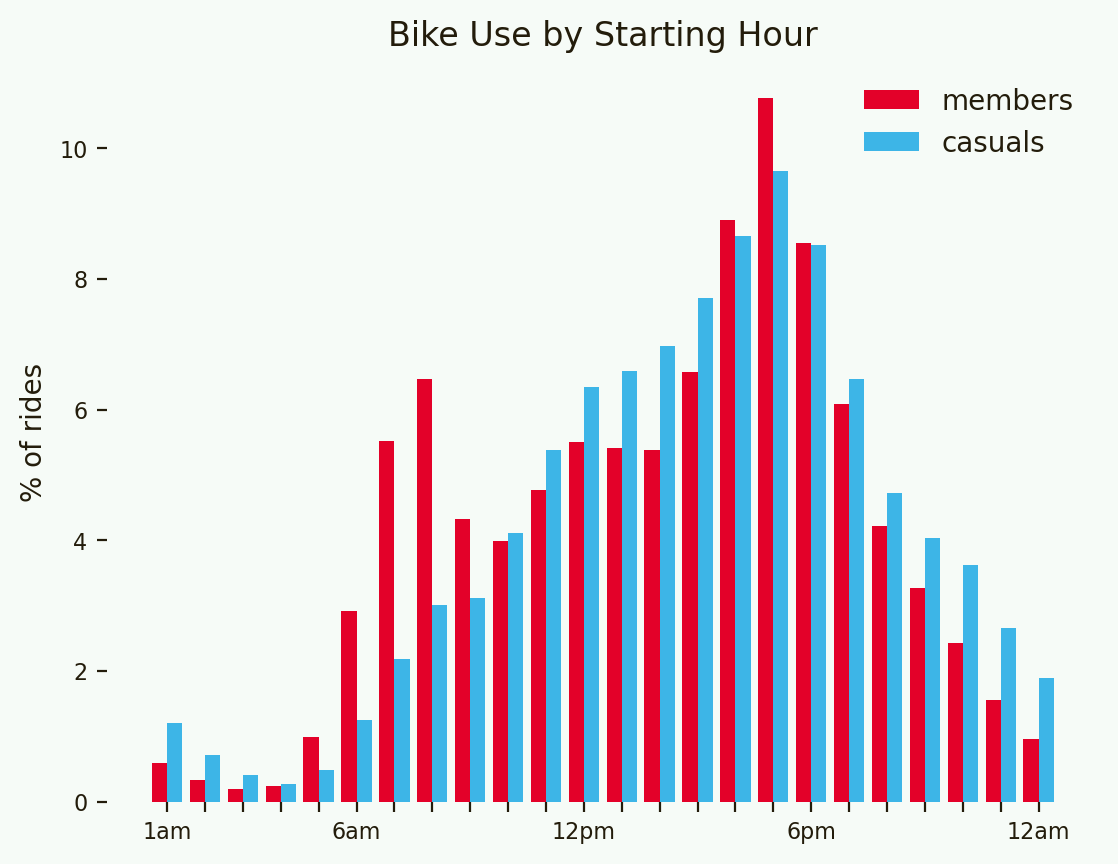

In [365]:
useHour = pd.DataFrame({'casuals': 100*casuals['started_at'].dt.hour.value_counts()/lenCas, 
                       'members': 100*members['started_at'].dt.hour.value_counts()/lenMem})
useHour = useHour.rename(index = {0:24}).sort_index()
    
#plot start hour percentages
X_axis = np.arange(len(useHour))
xLabels = ['1am']+['']*4+['6am']+['']*5+['12pm']+['']*5+['6pm']+['']*5+['12am']

plt.bar(X_axis - 0.2, list(useHour['members']), 0.4, label = 'members', color = colorMem)
plt.bar(X_axis + 0.2, list(useHour['casuals']), 0.4, label = 'casuals', color = colorCas)

plt.xticks(X_axis, xLabels)
plt.ylabel("% of rides")
plt.title("Bike Use by Starting Hour")
plt.legend()
plt.savefig(figFolder+'hour.png')
plt.show()

There are definitely some differences here; let's plot the month, day, and hour variables in relation to one another instead to see if there are more meaningful useage patterns.

<bound method Figure.show of <Figure size 1000x1050 with 2 Axes>>

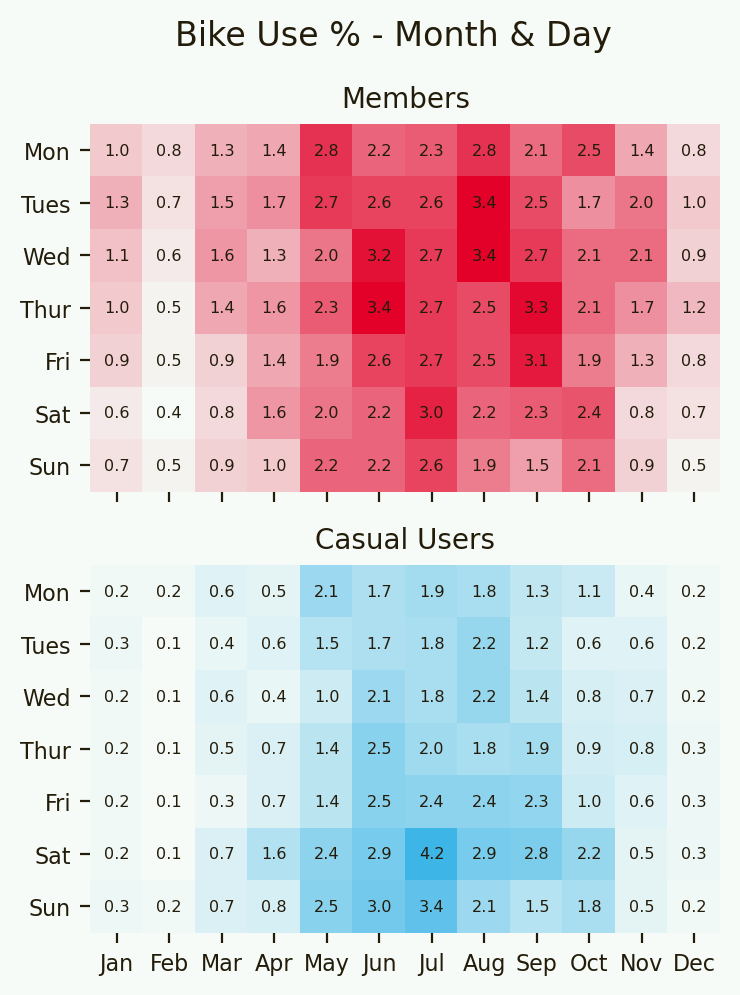

In [36]:
#get distribution of rides per month and day for casuals and members
monthDayCas = pd.DataFrame({'day': casuals['started_at'].dt.day_of_week, 'month': casuals['started_at'].dt.month}
                          ).value_counts(dropna=False).unstack()
monthDayCas = monthDayCas.apply(lambda x: round(100*x/lenCas, 1))
monthDayMem = pd.DataFrame({'day': members['started_at'].dt.day_of_week, 'month': members['started_at'].dt.month}
                          ).value_counts(dropna=False).unstack()
monthDayMem = monthDayMem.apply(lambda x: round(100*x/lenCas, 1))

#create figure and labels for months, days, and use percentage
fig, (axMem, axCas) = plt.subplots(2,1, sharex = True, figsize = (5,5.25))
fig.suptitle('Bike Use % - Month & Day')

monthLabels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                        'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
X_axis = np.arange(len(monthLabels))
axCas.set_xticks(X_axis, monthLabels)
axMem.set_xticks(X_axis, monthLabels)

dayLabels = np.array(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
Y_axis = np.arange(len(dayLabels))
axCas.set_yticks(Y_axis, dayLabels)
axMem.set_yticks(Y_axis, dayLabels)

axMem.set_title("Members", fontsize = 10)
axMem.imshow(monthDayMem, cmap = cmapMem)
axCas.set_title("Casual Users", fontsize = 10)
axCas.imshow(monthDayCas, cmap = cmapCas)

for i in range(len(monthDayMem)):
    for j in range(len(monthDayMem.columns)):
        text = axMem.text(j, i, monthDayMem.iloc[i, j], ha="center", va="center", color = colorBlack, fontsize = 'xx-small')
for i in range(len(monthDayCas)):
    for j in range(len(monthDayCas.columns)):
        text = axCas.text(j, i, monthDayCas.iloc[i, j], ha="center", va="center", color = colorBlack, fontsize = 'xx-small')

fig.savefig(figFolder+'monthDay.png')
fig.show

<bound method Figure.show of <Figure size 1000x700 with 2 Axes>>

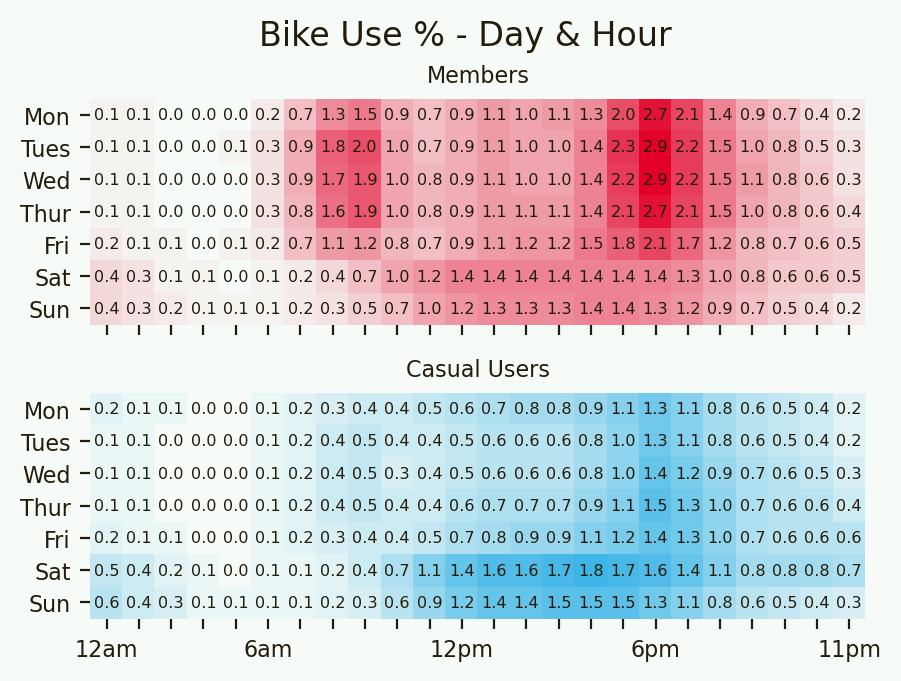

In [37]:
#get distribution of rides per day and hour for casuals and members
dayHourCas = pd.DataFrame({'day': casuals['started_at'].dt.day_of_week, 'hour': casuals['started_at'].dt.hour}
                         ).value_counts(dropna=False).unstack()
dayHourCas = dayHourCas.apply(lambda x: round(100*x/lenCas, 1))
dayHourMem = pd.DataFrame({'day': members['started_at'].dt.day_of_week, 'hour': members['started_at'].dt.hour}
                         ).value_counts(dropna=False).unstack()
dayHourMem = dayHourMem.apply(lambda x: round(100*x/lenCas, 1))

#create figure and labels for months, days, and use percentage
fig, (axMem, axCas) = plt.subplots(2,1, sharex = True, figsize = (5,3.5))
fig.suptitle('Bike Use % - Day & Hour')

X_axis = np.arange(len(useHour))
xLabels = ['12am']+['']*4+['6am']+['']*5+['12pm']+['']*5+['6pm']+['']*5+['11pm']
axCas.set_xticks(X_axis, xLabels)

dayLabels = np.array(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
Y_axis = np.arange(len(dayLabels))
axCas.set_yticks(Y_axis, dayLabels)
axMem.set_yticks(Y_axis, dayLabels)

axMem.set_title("Members", fontsize = 8)
axMem.imshow(dayHourMem, cmap = cmapMem)
axCas.set_title("Casual Users", fontsize = 8)
axCas.imshow(dayHourCas, cmap = cmapCas)

for i in range(len(dayHourMem)):
    for j in range(len(dayHourMem.columns)):
        text = axMem.text(j, i, dayHourMem.iloc[i, j], ha="center", va="center", color = colorBlack, fontsize = 'xx-small')
for i in range(len(dayHourCas)):
    for j in range(len(dayHourCas.columns)):
        text = axCas.text(j, i, dayHourCas.iloc[i, j], ha="center", va="center", color = colorBlack, fontsize = 'xx-small')

fig.savefig(figFolder+'dayHour.png')
fig.show

There are definite use patterns here.
+ The casual segment is dominated by summer weekend use between lunch and dinner time, with weekday use linked to the end of the standard workday.
+ The annual member segment is more widespread in the warm half of the year, with the dominant use case being evening commuting times during the standard work week, moderate use around morning commute work week hours, and scattered use on the weekend hours between lunch and dinner.

It seems members are warm-weather commuters, whereas casual users are going for summer weekend outings.

### Use distributions - how long do users ride, and which bikes do they prefer?

let's compare how long users spend with a bike.

<bound method Figure.show of <Figure size 1280x960 with 1 Axes>>

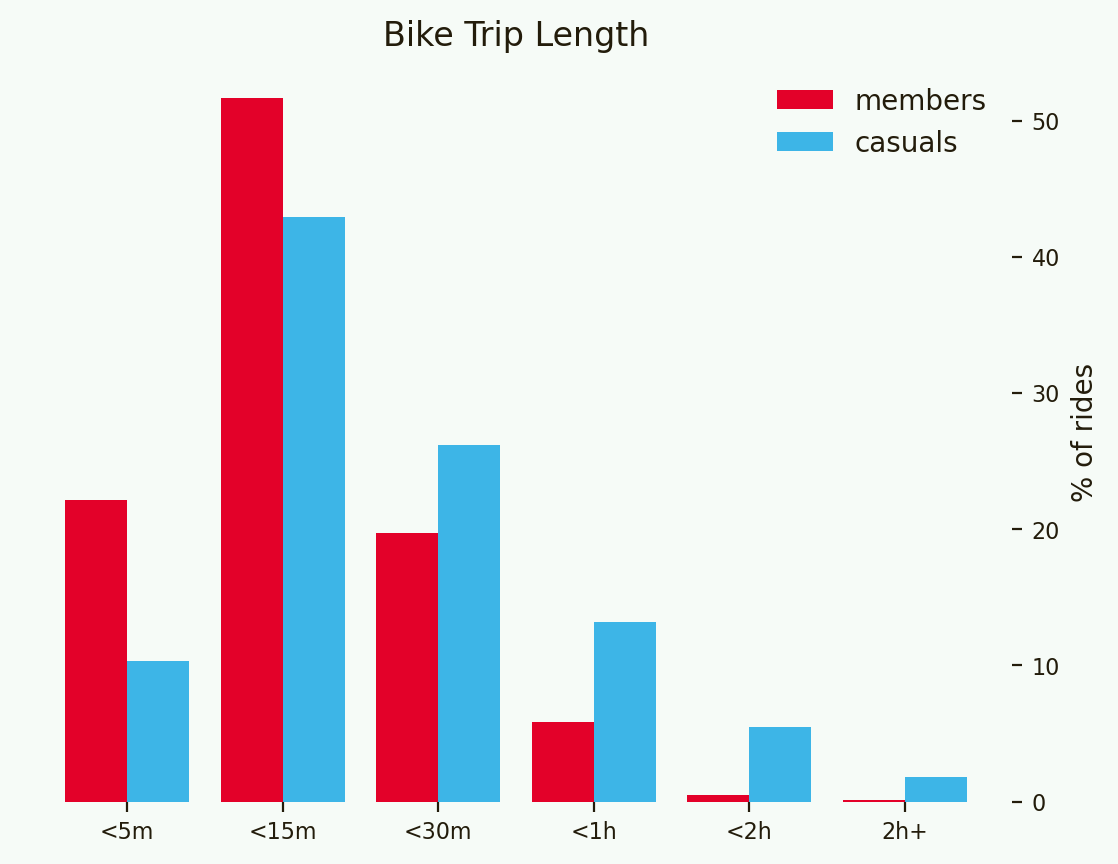

In [38]:
#sort trip durations into bins to get a higher level understanding of trip length
timeBins = [np.timedelta64(0, 'm'),
            np.timedelta64(5, 'm'),
            np.timedelta64(15, 'm'), 
            np.timedelta64(30, 'm'),
            np.timedelta64(1, 'h'),
            np.timedelta64(2, 'h'),
            np.timedelta64(10, 'D'),]
rideLengthCas = pd.cut(casuals['ride_duration'], bins = timeBins)
rideLengthMem = pd.cut(members['ride_duration'], bins = timeBins)

#get percentage use for each bin
tripDurations = pd.DataFrame({'casuals': rideLengthCas.value_counts().sort_index(),
                              'members': rideLengthMem.value_counts().sort_index()})
tripDurations['casuals'] = 100*tripDurations['casuals']/lenCas
tripDurations['members'] = 100*tripDurations['members']/lenMem

#plot trip duration percentages
durationBinLabels = np.array(['<5m', '<15m', '<30m', '<1h', '<2h', '2h+'])
X_axis = np.arange(len(durationBinLabels))

fig, ax = plt.subplots(1,1) 
ax.bar(X_axis - 0.2, list(tripDurations['members']), 0.4, label = 'members', color = colorMem)
ax.bar(X_axis + 0.2, list(tripDurations['casuals']), 0.4, label = 'casuals', color = colorCas)

ax.set_xticks(X_axis, durationBinLabels)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel("% of rides")
ax.set_title("Bike Trip Length")
ax.legend()
fig.savefig(figFolder+'length.png')
fig.show

This seems to track with the previous insight.
+ If casual users are going out for pleasure rides instead of quickly trying to get to work, it makes sense that they're riding for longer than their member counterparts.
+ Cycling blog Bike Push researched several data sources to investigate the average speed of bike commutes in [this article.](https://bikepush.com/average-commuter-bike-speed/) Their conclusion was that city bikers see an average of ~12.5mph. At that speed, the median member is riding around 3 miles on their average trip.
+ We can theorize that Divvy users predominately use bike shares to extend the area they can quickly reach from public transport or on foot, not as a means of moderate/long distance travel.

let's compare which bike types users prefer.

<bound method Figure.show of <Figure size 1280x960 with 2 Axes>>

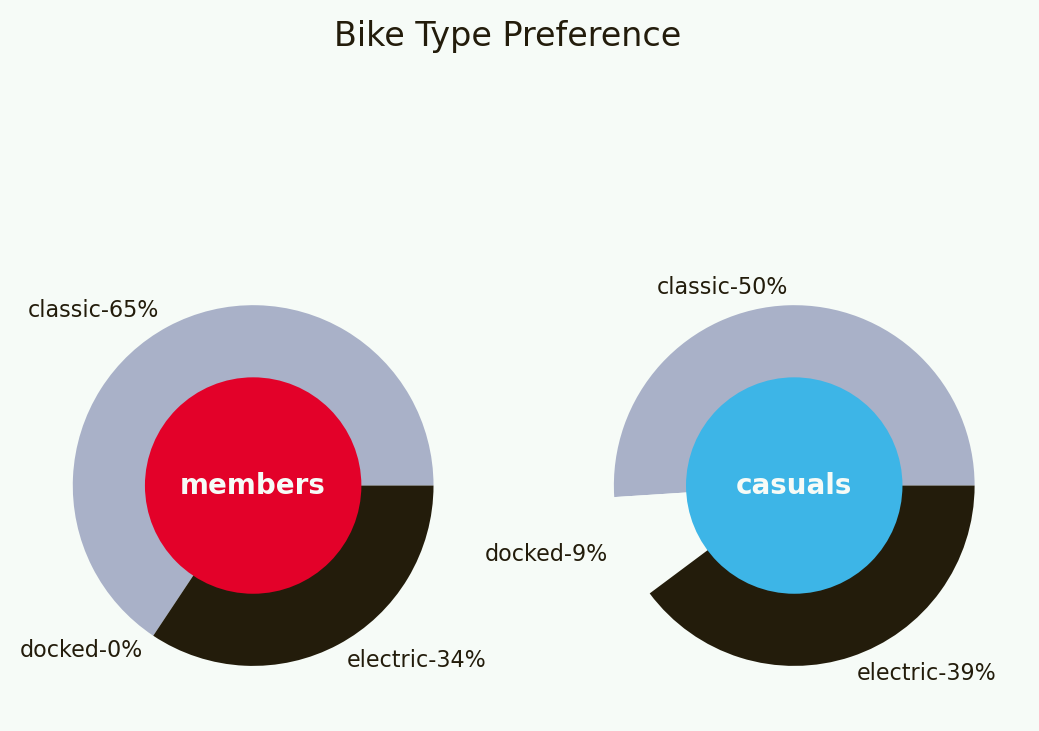

In [363]:
#calculate bike type use percentages
bikeTypeUse = pd.DataFrame({'casuals': 100*casuals['rideable_type'].value_counts()/lenCas, 
                       'members': 100*members['rideable_type'].value_counts()/lenMem}).fillna(0)
bikeTypeUse = bikeTypeUse.astype(int)

fig, (axMem, axCas) = plt.subplots(1,2)

bikeTypes = list(bikeTypeUse.index.str.replace('_bike', ''))
typesMem = []
typesCas = []
for i, j in zip(bikeTypes, bikeTypeUse['members']):
    typesMem.append(i+'-'+str(j)+'%')
for i, j in zip(bikeTypes, bikeTypeUse['casuals']):
    typesCas.append(i+'-'+str(j)+'%')
pieColors = [colorGray, colorWhite, colorBlack]
 
#plot bike type distribution for members and casuals
axMem.pie(bikeTypeUse['members'], colors = pieColors, labels=typesMem, labeldistance=1.1)
axMem.add_patch(plt.Circle((0, 0), 0.6, fc = colorMem))
axMem.annotate('members', xy = (0, 0), fontsize = 10, color = colorWhite,
                          fontweight = 'bold', ha = 'center', va = 'center')
axCas.pie(bikeTypeUse['casuals'], colors = pieColors, labels=typesCas, labeldistance=1.1)
axCas.add_patch(plt.Circle((0, 0), 0.6, fc = colorCas))
axCas.annotate('casuals', xy = (0, 0), fontsize = 10, color = colorWhite,
                          fontweight = 'bold', ha = 'center', va = 'center')

fig.suptitle('Bike Type Preference')
fig.savefig(figFolder+'type.png')
fig.show

Looks like while members are likely to prefer classic bikes, casual users are more ecclectic in their preferences. If we're trying to capture casual users who resemble existing members, we should focus on classic bikes, but the casuals as a class don't have a preference worth catering towards.

### Use distribution - which stations do riders use?

As we saw earlier, there are tons of stations, and I assume some stations see much more use than others; if Divvy wants to run any staffed promotional event or deploy marketing material, it'd be valuable to know which stations will get them the most engagements for their effort. Let's find and map the top stations while checking if there are other interesting patterns in the data.

first, let's define some functions that:
+ find the most used stations for a given set of records
+ add markers to an interactive folium map
+ create static maps of the top stations using matplotlib
+ tell us the what percent of total visits a set of stations account for

In [139]:
#creates a df of most used stations, their ride count, and their most common coordinates
def get_top_stations(stationDf, nStations):
    #get top stations
    topNStations = pd.concat([stationDf['start_station_name'], 
                       stationDf['end_station_name']]).value_counts().nlargest(nStations).reset_index()
    topNStations.columns = ['station', 'visits']
        
    #get coords of top stations
    topCoords = pd.merge(topNStations, stationCoords, on = 'station', how = 'inner')
    topCoords['coords'] = list(zip(round(topCoords['lat'], 6), round(topCoords['lon'], 6)))
    topCoords = pd.DataFrame(topCoords.groupby('station').value_counts()).reset_index()
    topCoords = topCoords.rename({0: 'occurrence'}, axis=1)
    topCoords = topCoords.groupby('station').nth(0).sort_values('visits', ascending=False).reset_index()
    topCoords['rank'] = topCoords.index+1
    topCoords = topCoords[['rank'] + [x for x in topCoords.columns if x != 'rank']]
               
    return(topCoords)

In [42]:
#creates a function that adds markers to a map from a df of points
def create_point_layer(pointDf, mapName, coordColName = 'coords', color = '#FFFFFF', userGroup = ''):
    stationMarkers = folium.FeatureGroup(name = userGroup)
    for i in range(0,len(pointDf)):
        stationMarkers.add_child(folium.Marker(
            location = pointDf.iloc[i][coordColName],
            tooltip = folium.Tooltip(' '.join([pointDf.iloc[i]['station'], '- no.'+str(i+1), '<br>with', 
                str(pointDf.iloc[i]['visits']), userGroup, 'visits.']), style = 'font-size:14px;'),
            icon = BeautifyIcon(number = pointDf.index[i]+1, background_color = color, border_color = 'transparent'),
            opacity = .7
        )).add_to(mapName)
    return(stationMarkers)

In [613]:
#creates matplotlib figure with minimap, marked map zoomed to top stations, and table listing top stations
def graph_top_stations(rankedStationDf, userType, totalVisits, markColor):
    colorGreen = '#008800'

#get bounding box of coordinates from list with a given buffer value
    buffer = .05
    xMin = rankedStationDf['lon'].min()
    xMax = rankedStationDf['lon'].max()
    xBuffer = (xMax-xMin)*buffer
    yMin = rankedStationDf['lat'].min()
    yMax = rankedStationDf['lat'].max()
    yBuffer = (yMax-yMin)*buffer
    xMinBuff = xMin - max(xBuffer, yBuffer)
    xMaxBuff = xMax + max(xBuffer, yBuffer)
    yMinBuff = yMin - max(xBuffer, yBuffer)
    yMaxBuff = yMax + max(xBuffer, yBuffer)
     
#create figure and axes for graphics 
    fig = plt.figure(dpi=200)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.05, hspace=.05)

    gs = GridSpec(3, 3, figure=fig)
    miniAx = fig.add_subplot(gs[0, 0])
    pieAx = fig.add_subplot(gs[-1, 0])
    zoomAx = fig.add_subplot(gs[:, 1])
    tableAx = fig.add_subplot(gs[:, 2])

    miniAx.set_anchor('E')
    pieAx.set_anchor('E')
    tableAx.set_anchor('W')
    
#plot minimap
    cityDf.plot(ax = miniAx, facecolor = colorGray, zorder = 0)
    parkDf.plot(ax = miniAx, facecolor = colorGreen)
    miniAx.add_patch(matplotlib.patches.Rectangle((xMinBuff, yMinBuff), xMaxBuff-xMinBuff, yMaxBuff-yMinBuff, 
                                                  facecolor = '#ffffff77', linewidth = .5, edgecolor = colorBlack))
#plot zoomed in map with top stations labeled with their rank
    zoomAx.set_xlim([xMinBuff, xMaxBuff])
    zoomAx.set_ylim([yMinBuff, yMaxBuff])
    nbhdDf.plot(ax = zoomAx, facecolor = 'white', edgecolor = colorBlack, linewidth = .5)
    parkDf.plot(ax = zoomAx, facecolor = colorGreen+'55')
    zoomAx.scatter(x = rankedStationDf['lon'], y = rankedStationDf['lat'], s = 50, 
                   color = markColor+'99', edgecolor = colorBlack, linewidth = .5)
    zoomAx.add_patch(matplotlib.patches.Rectangle((xMinBuff, yMinBuff), xMaxBuff-xMinBuff, yMaxBuff-yMinBuff, 
                                                  facecolor = 'none', linewidth = 1.25, edgecolor = colorBlack))
    for idx, row in rankedStationDf.iloc[::-1].iterrows():
        zoomAx.annotate(text = row['rank'], xy = (row['lon'], row['lat']), size = 4, fontweight = 'bold',
                       horizontalalignment='center', verticalalignment = 'center', color = colorBlack,
                       path_effects = [path_effects.Stroke(linewidth=1, foreground=colorWhite),
                       path_effects.Normal()])
    zoomAx.patch.set_facecolor('white')
#connect minimap and zoomed in map
    con1 = ConnectionPatch(xyA = (xMinBuff, yMaxBuff), coordsA = miniAx.transData,
                           xyB = (xMinBuff, yMaxBuff), coordsB = zoomAx.transData, 
                           color = 'black', linewidth = .3, zorder = 2)
    fig.add_artist(con1)
    con2 = ConnectionPatch(xyA = (xMinBuff, yMinBuff), coordsA = miniAx.transData,
                           xyB = (xMinBuff, yMinBuff), coordsB = zoomAx.transData, 
                           color = 'black', linewidth = .3, zorder = 2)
    fig.add_artist(con2)
#plot pie chart of visits covered by top stations
    topVisits = rankedStationDf['visits'].sum()
    pieAx.pie([topVisits, totalVisits-topVisits], colors = [markColor, colorBlack], 
              labels=['top '+str(len(rankedStationDf))+'\nstations', ''], labeldistance=1.2, textprops={'fontsize': 5})
    pieAx.add_patch(plt.Circle((0, 0), 0.6, fc = colorWhite))
    pieAx.annotate('visits by\n'+userType, xy = (0, 0), fontsize = 10, color = colorBlack,
                   fontweight = 'bold', ha = 'center', va = 'center',
                   path_effects = [path_effects.Stroke(linewidth=1.5, foreground=colorWhite),
                       path_effects.Normal()])
#plot tabel of top stations
    stationTable = tableAx.table(cellText = rankedStationDf[['rank', 'station', 'visits']].values, loc = 'center',
                  colLabels = ['rank', 'top '+str(len(rankedStationDf))+' stations for '+userType, 'visits'],
                  colWidths = [.1, .75, .15], fontsize = 5, edges = 'horizontal', bbox = [0,0,1,1])
    for (row, col), cell in stationTable.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

#deal
    for ax in [miniAx, pieAx, zoomAx, tableAx]:
        ax.axis('off')
        ax.margins(x = 0, y = 0)
    fig.tight_layout()
    

In [538]:
#creates a message stating what percent of total visits a given user type's top visited stations account for
def station_pct_msg(stationDf, userGroup = '', userGroupLen = 0):
    #manage user type
    if userGroup in ['', None]:
        userPad = ('', ' ', '.')
    else:
        userPad = ('by '+userGroup+' ', 'ir ',
                   ', '+(str(round(100*stationDf['visits'].sum()/userGroupLen,2)))+'% of '+userGroup+' visits.')
    #manage singular versus plural station grammar
    if len(stationDf) == 1:
        numpPad = 'most used station '
    else:
        numPad = 'top '+str(len(stationDf))+' most used stations '
    #calculate use percentage
    usePercentage = str(round(100*stationDf['visits'].sum()/lenTot,2))+'%'
        
    #create message string
    return(''.join(['visits ', userPad[0], 'to the', userPad[1],
                    numPad, 'account for ', usePercentage, ' of all visits', userPad[2]]))

Now that we've defined our functions, let's get the top 30 stations for all users, members, and casual users.

In [140]:
topStations = get_top_stations(df, 30)
topStationsMem = get_top_stations(members, 30)
topStationsCas = get_top_stations(casuals, 30)

Let's make in interactive map of the 30 most visited stations for members, casual users, and for all bike users.

In [428]:
#load map of the city with a graphical layer control
f = folium.Figure(width=600, height=1200)
m = folium.Map(tiles = 'Stamen Terrain', location=[41.85, -87.65], zoom_start=12, control_scale = True).add_to(f)

#add map tile sets
folium.raster_layers.TileLayer('Open Street Map').add_to(m)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(m)
folium.raster_layers.TileLayer('Stamen Toner').add_to(m)

#add boundary of city to map
m.add_child(folium.GeoJson(data = geoFolder+'nbhd.geojson', style_function = lambda x: {'fillOpacity': '0.05', 'color': colorBlack}))

#add points to map
create_point_layer(topStations, m, color = colorWhite, userGroup = 'all').add_to(m)
create_point_layer(topStationsCas, m, color = colorCas, userGroup = 'casual').add_to(m)
create_point_layer(topStationsMem, m, color = colorMem, userGroup = 'member').add_to(m)

folium.LayerControl().add_to(m)
m

From our map, we can see there's some overlap between the most used sites by casuals and members and the most overall visited sites, with use centered around Central Chicago's Near North Side, Loop, and Near South Side neighborhoods, but there are some definite differences. The highest member use forms a long band within 3 miles of the shore between Northerly Island and Lincoln Park, with highest use centered around the Harbor; there's also a small but notable separate pocket of use around Washington and Jackson Parks to the South. Casual use forms a more circular cluster which is centered on but excludes the Near South Side neighborhood, which contains the City's tallest buildings.

let's create some static graphics of the same data.

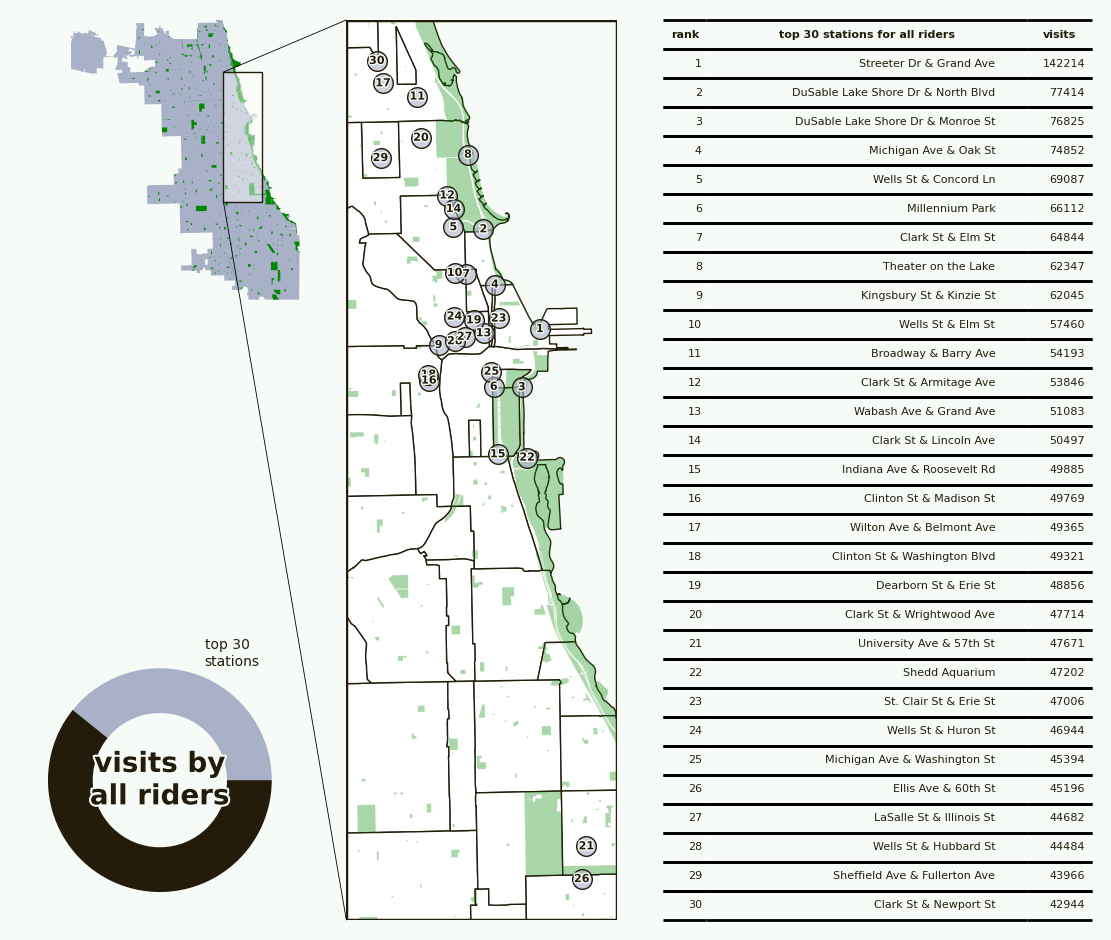

In [615]:
graph_top_stations(topStations, 'all riders', lenTot, colorGray)
fig = plt.gcf()
fig.savefig(figFolder+'topAll.png')

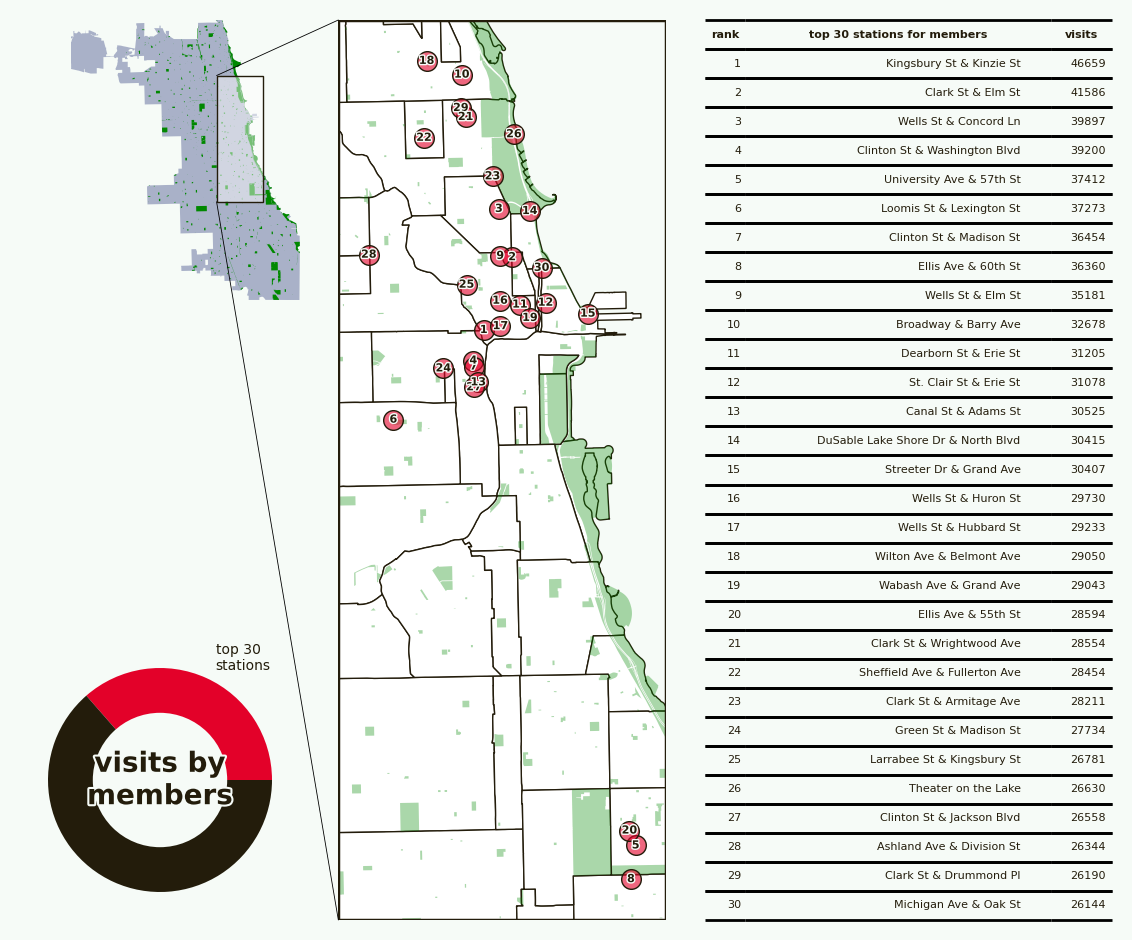

In [616]:
graph_top_stations(topStationsMem, 'members', lenMem, colorMem)
fig = plt.gcf()
fig.savefig(figFolder+'topMem.png')

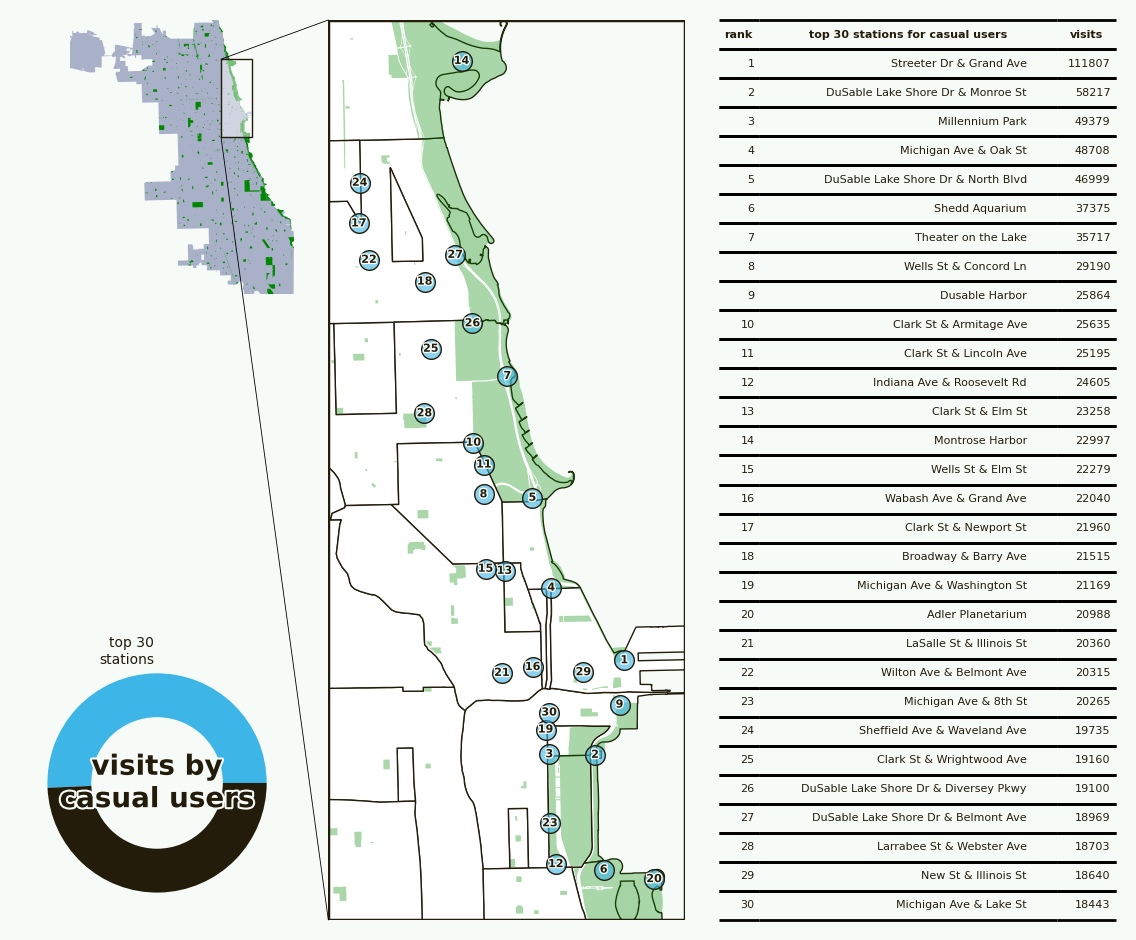

In [617]:
graph_top_stations(topStationsCas, 'casual users', lenCas, colorCas)
fig = plt.gcf()
fig.savefig(figFolder+'topCas.png')

In [45]:
print(station_pct_msg(topStations))
print(station_pct_msg(topStationsCas, userGroup = 'casual users', userGroupLen =lenCas))
print(station_pct_msg(topStationsMem, userGroup = 'annual members', userGroupLen = lenMem))

visits to the top 30 most used stations account for 39.2% of all visits.
visits by casual users to their top 30 most used stations account for 20.33% of all visits, 50.71% of casual users visits.
visits by annual members to their top 30 most used stations account for 21.82% of all visits, 36.43% of annual members visits.


Now THERE's something interesting; a mere 30 stations account for over HALF of all visits for casual users.

### Further research - 
Several thoughts outside the scope of the business question caught my attention during analysis, some about the data set and some about the Divvy survice in general. Investigating these questions via diagnostic research, customer survey, or communication with Divvy employees could result in new, better, or otherwise more useful data being collected in the future, and in the creation of new opportunities for profit.
##### Dataset questions - 
+ What does the "docked bike" catagory represent? Divvy marketing info indicates ALL Divvy bikes must be borrowed from and returned to docks; the fact that the trips using docked bikes have different start and end points suggests these aren't errors where a bike logged a trip even though they were still in a dock. They also only account for a tenth of use instances. Should these bikes be coded differently? Web searches and investigation of Divvy's website don't yeild any obvious answers.
+ Why is some of the data for start/end locations missing, both in station code, station name, and lat-long coordinates? Does this missing data stem from bike misuse, hardware malfunction, or software error? The percentage of records with missing location data seems too large to be the result of random errors.
##### New business questions - 
+ Members prefer classic bikes to electrics; are some weekday casual riders deterred from becoming members due to a supply issue when it comes to their prefered type?
+ There are significant periods of time where demand is low, and thus a large portion of the Divvy fleet is not being capitalized on. Should Divvy consider offering incentives such as reduced rates during these off-peak hours in order to leverage their bike supply more effectively?

## Conclusions - who are the casuals and the members?

+ The average existing Divvy member is likely a warm-weather, classic-bike loving commuter who works near the city center. Over one third of them will start or end their trip at one of 30 stations in Central Chicago, and their average trip is under 4 miles.
+ the average casual Divvy user rides a shared bike on summer weekend afternoons, somewhat preferring classic bikes to electrics. While they also tend to take short rides, they're more likely to ride for longer than their member counterparts, and over half of them start or end their trip at one  of 30 stations in a small geographic area.

## Suggestions - how do we capitalize on these user profiles?

+ Trips where casual users visited one of their top 30 favorite stations count for over half of all casual visits. Any physical ad campaign, promotion, survey effort, or special event deployed by Divvy realistically needs to target very few stations to impact a large amount of casual users. If Divvy's marketing team wants to reach a different percentage of the casual user base, the necessary number of top stations can easily be calculated.
+ If Divvy wants to appeal to casual customers who resemble existing members, marketing efforts should focus on communicating how much time and money they can save with a Divvy membership as a daily part of their commute, contrasting time spent traveling with what they could be doing each morning or evening.
+ If Divvy wants to capture a new demographic of members consisting of the existing casual users, marketing efforts should focus on connecting bike use with a life more filled with joy derived from attending local events like restaurant tours or music festivals. Divvy should also explore partnering with local restaurants and entertainment venues near docking stations to offer special deals to Divvy members, adding value to memberships in exchange for venue promotion to the Divvy userbase. Promotion partners could be selected with the moderation of demand at specific stations in mind.
+ Divvy should invesitgate creating two new pass tiers - a weekend pass and a summer membership. Annual memberships may be too much of a commitment for many users; offering shorter, seemingly "tailor-made" plan options for preexisting use cases could appeal more directly to how customers see themselves using Divvy bikes.